## Loading

In [1]:
%load_ext autoreload
%autoreload 2

import model as m
import data_processing as dp
import feature_engineering as fe
import make_plots as mp
import parameters as p

import pandas as pd
import numpy as np
import warnings
from datetime import datetime,date
from datetime import timedelta
import evaluation as e

import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
warnings.filterwarnings("ignore")

default_max_rows = pd.get_option('display.max_rows')

c:\Users\Howard\anaconda3\envs\CZ_torch39\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Data Preprocessing

In [2]:
data_original = pd.read_csv("data/data_with_alpha_and_beta.csv")

### NAs in dataset

Number of columns before filtering: 367


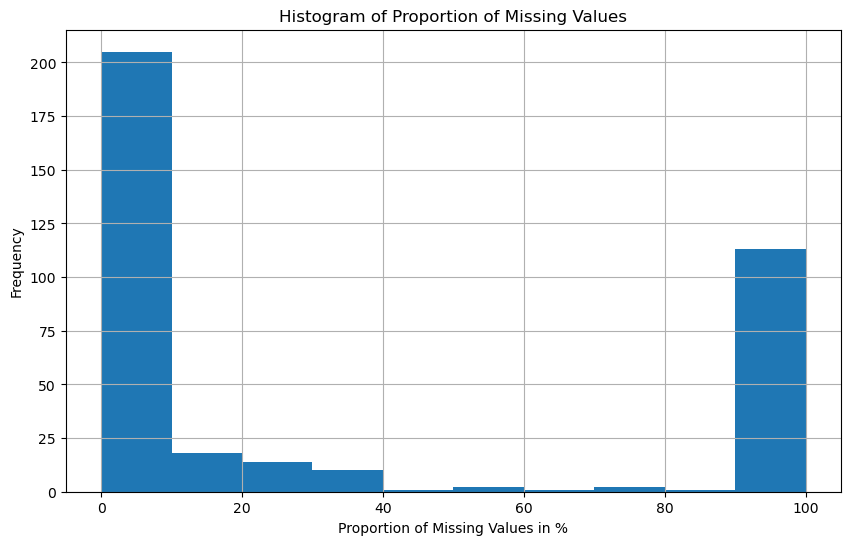

Number of columns after filtering: 202


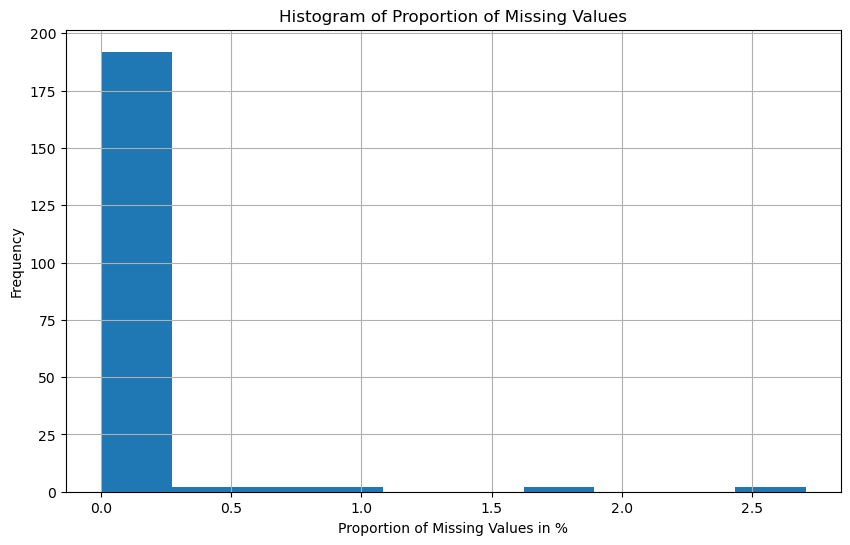

In [3]:
data = dp.data_loading(data_original)
print("="*120)
print("Number of columns before filtering:", data.shape[1])
mp.plot_missing_values(data)

data_filtered = dp.feature_filter(data)

print("="*120)
print("Number of columns after filtering:", data_filtered.shape[1])
mp.plot_missing_values(data_filtered)

In [4]:
bin_ranges = [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), 
              (50, 60), (60, 70), (70, 80), (80, 90), (90, 100)]

missing_values_proportion = pd.DataFrame(data.isna().mean() * 100, columns=['missing_values_proportion'])
missing_values_proportion['group'] = pd.cut(missing_values_proportion['missing_values_proportion'], bins=10, labels=bin_ranges)
grouped_data = missing_values_proportion.groupby(missing_values_proportion['group']).count().rename(columns={'missing_values_proportion': 'count'})
grouped_data.reset_index()



,group,count
0,"(0, 10)",205
1,"(10, 20)",18
2,"(20, 30)",14
3,"(30, 40)",10
4,"(40, 50)",1
5,"(50, 60)",2
6,"(60, 70)",1
7,"(70, 80)",2
8,"(80, 90)",1
9,"(90, 100)",113


In [5]:
top_bin = missing_values_proportion[missing_values_proportion['group'] == (90, 100)].sort_values(by='missing_values_proportion', ascending=False)
pd.set_option('display.max_rows', None)
print(top_bin)
pd.set_option('display.max_rows', default_max_rows)

                                               missing_values_proportion  \
Relative Robo Return20 Technology                             100.000000   
Relative Robo Return20 Real Estate                            100.000000   
Relative Robo Return60 Technology                             100.000000   
Relative Robo Return30 Technology                             100.000000   
Relative Robo Return10 Technology                             100.000000   
Relative Robo Return Technology                               100.000000   
Relative Robo Return90 Real Estate                            100.000000   
Relative Robo Return60 Real Estate                            100.000000   
Relative Robo Return30 Real Estate                            100.000000   
Relative Robo Return10 Real Estate                            100.000000   
Relative Robo Return30 Healthcare                             100.000000   
Relative Robo Return Real Estate                              100.000000   
Relative Rob

In [6]:
missing_values_proportion.sort_values(by='missing_values_proportion', ascending=False).to_csv("missing_values_proportion.csv")

In [7]:
pd.set_option('display.max_rows', None)
print(top_bin['missing_values_proportion'].sort_values(ascending=False))
pd.set_option('display.max_rows', default_max_rows)

Relative Robo Return20 Technology                100.000000
Relative Robo Return60 Healthcare                100.000000
Relative Robo Return20 Basic Materials           100.000000
Relative Robo Return30 Basic Materials           100.000000
Relative Robo Return60 Basic Materials           100.000000
Relative Robo Return90 Basic Materials           100.000000
Relative Robo Return Consumer Cyclical           100.000000
Relative Robo Return10 Consumer Cyclical         100.000000
Relative Robo Return20 Consumer Cyclical         100.000000
Relative Robo Return30 Consumer Cyclical         100.000000
Relative Robo Return60 Consumer Cyclical         100.000000
Relative Robo Return90 Consumer Cyclical         100.000000
Relative Robo Return10 Healthcare                100.000000
Relative Robo Return10 Consumer Defensive        100.000000
Relative Robo Return20 Consumer Defensive        100.000000
Relative Robo Return60 Consumer Defensive        100.000000
Relative Robo Return20 Healthcare       

### Feature being excluded by filtering (not feature selection)

In [8]:
excluded = [item for item in data.columns if item not in data_filtered.columns]
len(excluded), excluded

(165,
 ['inventory',
  'avg_inventory',
  'quick_ratio',
  'interest_exp',
  'operating_income',
  'times_interest_earned',
  'inventory_turnover',
  'businessAcqDisposals_QOQ',
  'businessAcqDisposals_YOY',
  'businessAcqDisposals_3YOY',
  'payDiv_QOQ',
  'payDiv_YOY',
  'payDiv_3YOY',
  'ncfx_QOQ',
  'ncfx_YOY',
  'ncfx_3YOY',
  'nonControllingInterests_QOQ',
  'nonControllingInterests_YOY',
  'nonControllingInterests_3YOY',
  'shareswaDil_QOQ',
  'shareswaDil_3YOY',
  'prefDVDs_QOQ',
  'prefDVDs_YOY',
  'prefDVDs_3YOY',
  'intexp_QOQ',
  'intexp_YOY',
  'intexp_3YOY',
  'netIncDiscOps_QOQ',
  'netIncDiscOps_YOY',
  'netIncDiscOps_3YOY',
  'rnd_QOQ',
  'rnd_YOY',
  'rnd_3YOY',
  'deposits_QOQ',
  'deposits_YOY',
  'deposits_3YOY',
  'debtCurrent_YOY',
  'debtCurrent_3YOY',
  'investmentsNonCurrent_QOQ',
  'investmentsNonCurrent_YOY',
  'investmentsNonCurrent_3YOY',
  'taxLiabilities_QOQ',
  'taxLiabilities_YOY',
  'taxLiabilities_3YOY',
  'inventory_QOQ',
  'inventory_YOY',
  'invent

## Imputation

In [9]:
data_imputed = dp.fillnas_and_convert(data, "M")

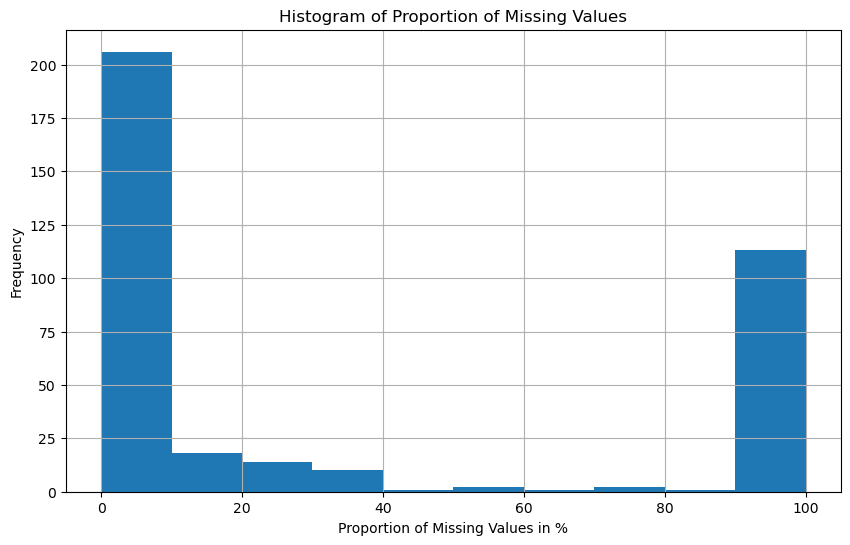

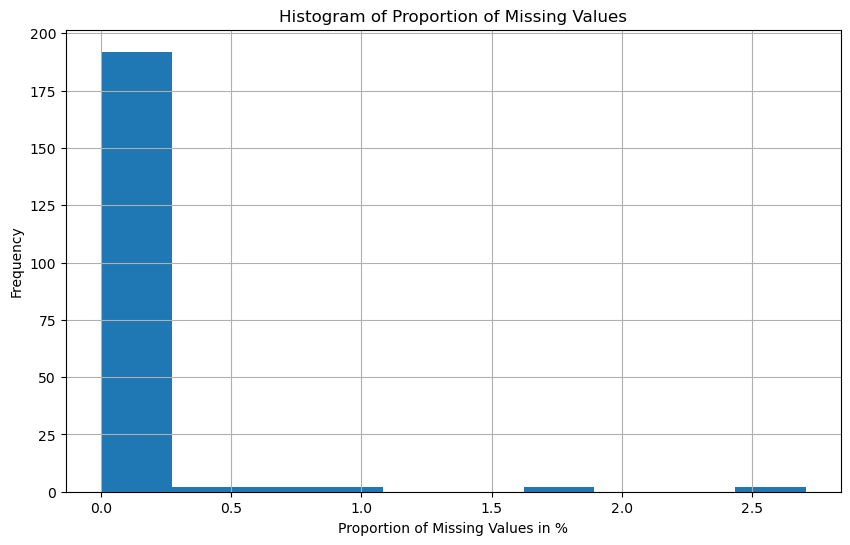

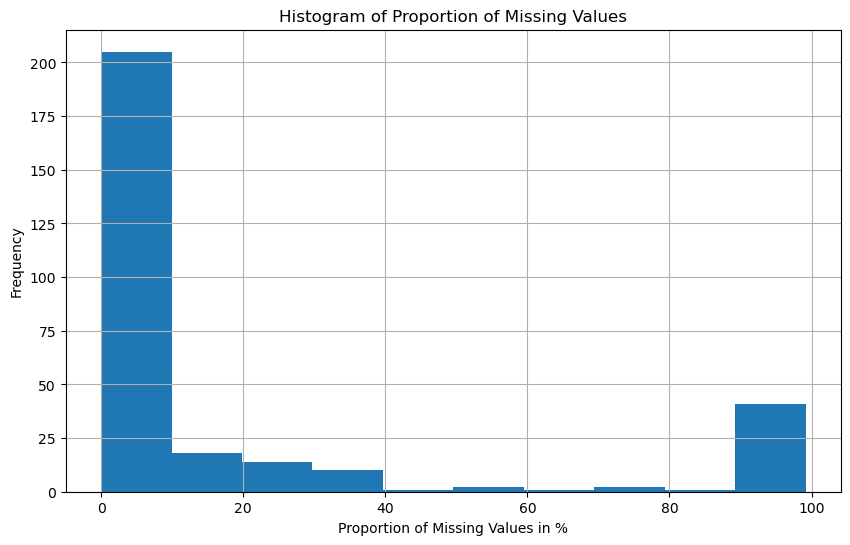

In [10]:
mp.plot_missing_values(data_original)
mp.plot_missing_values(data_filtered)
mp.plot_missing_values(data_imputed)

In [11]:
missing_values_proportion = pd.DataFrame(data_imputed.isna().mean() * 100, columns=['missing_values_proportion'])
missing_values_proportion['group'] = pd.cut(missing_values_proportion['missing_values_proportion'], bins=10, labels=bin_ranges)

pd.set_option('display.max_rows', None)
print(missing_values_proportion.sort_values(by="missing_values_proportion", ascending=False))
pd.set_option('display.max_rows', default_max_rows)

data_imputed[data_imputed['inventory'].isna()]['Ticker'].unique()
# na for some tickers

                              missing_values_proportion      group
prefDVDs                                      99.168819  (90, 100)
issrepayDebt                                  98.878309  (90, 100)
freeCashFlow                                  98.878309  (90, 100)
ncff                                          98.878309  (90, 100)
investmentsAcqDisposals                       98.878309  (90, 100)
businessAcqDisposals                          98.878309  (90, 100)
issrepayEquity                                98.878309  (90, 100)
ncf                                           98.878309  (90, 100)
ncfi                                          98.878309  (90, 100)
sbcomp                                        98.878309  (90, 100)
rnd                                           98.878309  (90, 100)
depamor                                       98.878309  (90, 100)
ncfo                                          98.878309  (90, 100)
prefDVDs_3YOY                                 98.733054  (90, 

array(['ADP', 'ADSK', 'ANSS', 'BKNG', 'CHTR', 'CMCSA', 'CTSH', 'EBAY',
       'FISV', 'INTU', 'KHC', 'MTCH', 'NFLX', 'PANW', 'PAYX', 'VRSK',
       'VRSN'], dtype=object)

## Feature Selection

### XGBoost

In [12]:
percentage_of_the_data_to_use = 1 # 0.1 for testing, save some time, change when needed
end = int(len(data_imputed) * percentage_of_the_data_to_use)

X = data_imputed.drop(['alpha', 'Ticker', 'sector'],axis=1)[:end] 
Y = data_imputed['alpha'][:end]

In [13]:
xgb_model = m.XGBoostModel()
xgb_model.fit(X, Y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

6.666666666666667 %


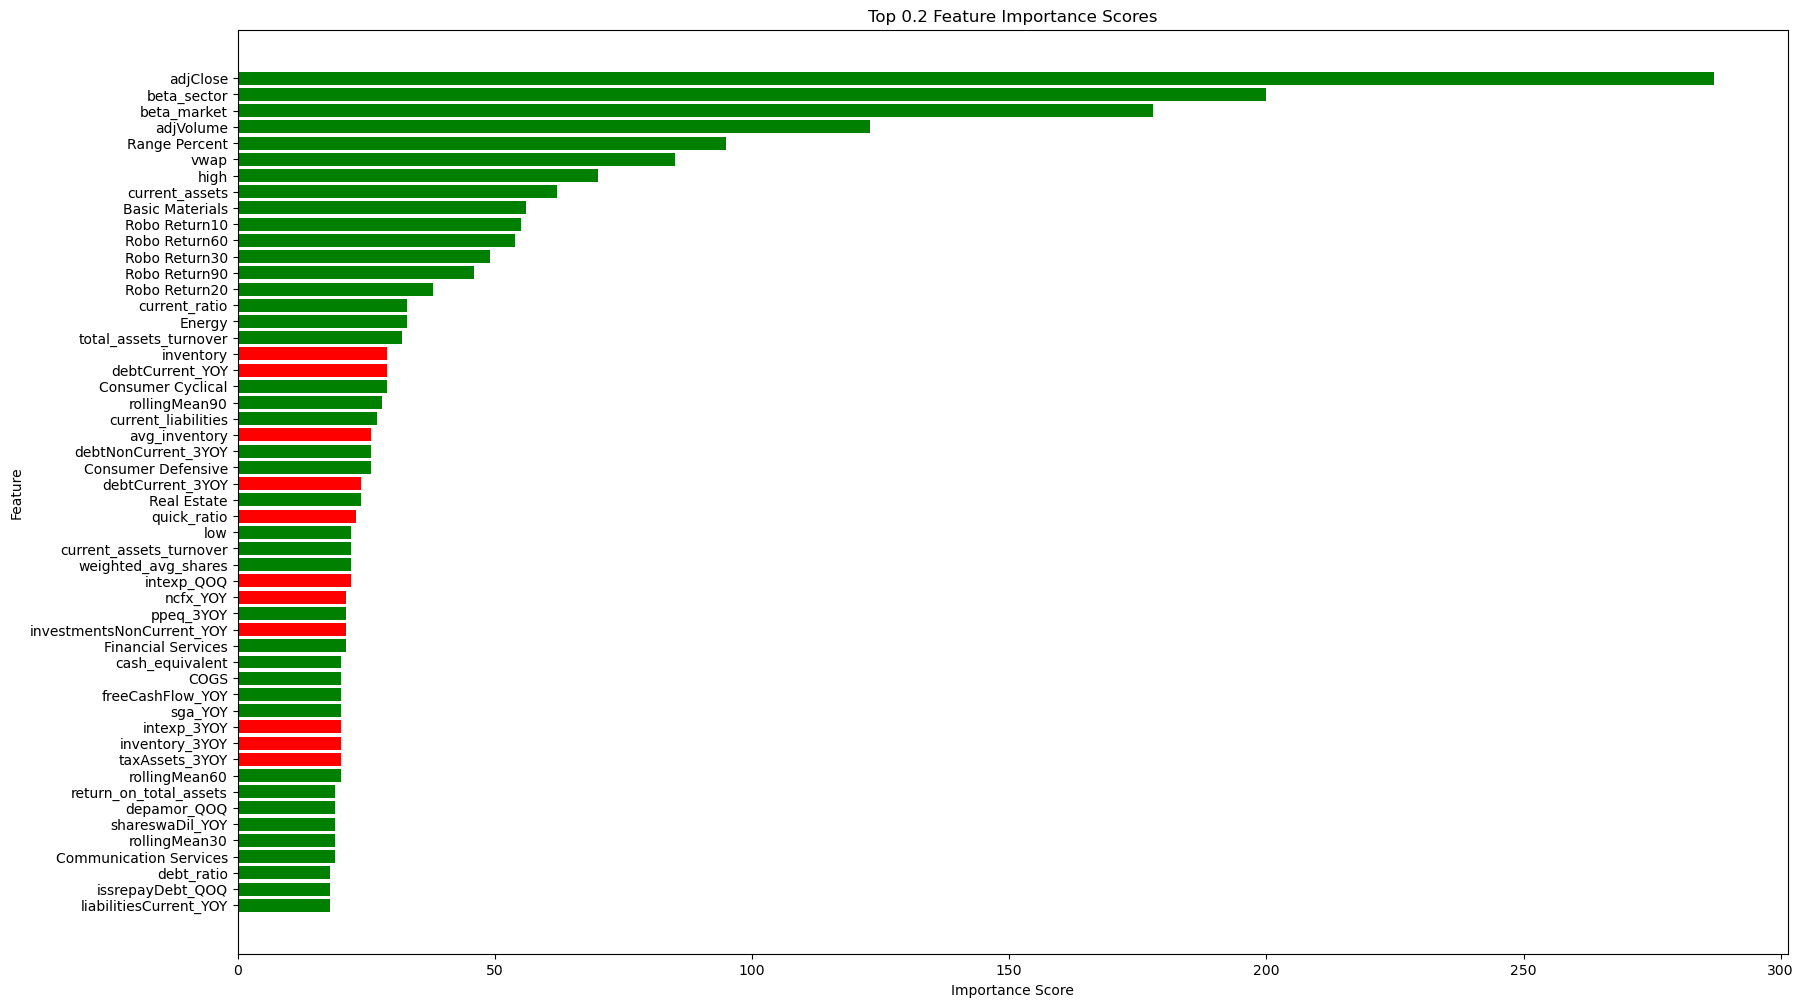

In [14]:
importance_scores = xgb_model.model.get_booster().get_score(importance_type="weight")
sorted_importance = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

top_percentage = 0.2
top_n = int(len(sorted_importance) * top_percentage)
top_features = [x[0] for x in sorted_importance[:top_n]]
top_scores = [x[1] for x in sorted_importance[:top_n]]

xgboost_shoudnotbeexcluded = [item for item in top_features if item in excluded] 
print("="*120)
print(len(xgboost_shoudnotbeexcluded) / len(excluded) * 100, "%")
print("="*120)

plt.figure(figsize=(20, 12))
for feature, score in zip(top_features, top_scores):
    color = "red" if feature in xgboost_shoudnotbeexcluded else "green"
    plt.barh(feature, score, color=color)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title(f"Top {top_percentage} Feature Importance Scores")
plt.gca().invert_yaxis() 
plt.show()

In [15]:
dp.filter_by_market_capitalization(data)

(Index(['AAPL', 'ADI', 'ADP', 'AEP', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ASML',
        'ATVI', 'AVGO', 'BIIB', 'BKNG', 'CMCSA', 'COST', 'CSCO', 'CSX', 'CTSH',
        'DLTR', 'EA', 'EBAY', 'EXC', 'FISV', 'GILD', 'GOOGL', 'HON', 'ILMN',
        'INTC', 'INTU', 'ISRG', 'KLAC', 'LRCX', 'MAR', 'MDLZ', 'MRVL', 'MSFT',
        'MU', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'PAYX', 'PCAR', 'PEP', 'QCOM',
        'REGN', 'ROST', 'SBUX', 'TMUS', 'TSLA', 'TXN', 'VRTX', 'WBA', 'XEL',
        'XLNX'],
       dtype='object', name='Ticker'),
 Index(['ADSK', 'ALGN', 'ANSS', 'CDNS', 'CHTR', 'CPRT', 'CTAS', 'DXCM', 'FAST',
        'FTNT', 'IDXX', 'KDP', 'LULU', 'MCHP', 'MELI', 'MNST', 'MTCH', 'SGEN',
        'SIRI', 'SNPS', 'SWKS', 'VRSK', 'VRSN'],
       dtype='object', name='Ticker'))

## Baseline MOdel

## TFT Model

### Preprocessing

In [16]:
# data_fs = dp.data_preprocessing(data)
# last_day = data_fs['date'].max() # type: datetime
# year_list = [x for x in range(2018,2024)]
# output_df = pd.DataFrame()

# year = 2018
# for year in year_list:
#     day_to_train = last_day.day
#     month_to_train = last_day.month
#     data = data_fs[lambda x: x['date'] <= datetime(year,month_to_train,day_to_train)]
#     # data = my_tft.hurdle_training(data, hurdle_rate=0.9)
#     training, validation, train_dataloader, val_dataloader = my_tft.split_train_val(data)
#     best_tft = my_tft.train_model(training, train_dataloader, val_dataloader)
#     ticker_series, actuals_series, predict_series = my_tft.get_validation_result(best_tft, training, val_dataloader)
#     top_n_features = my_tft.get_interpretation(best_tft, training, val_dataloader)
#     output_year = pd.concat([ticker_series, actuals_series, predict_series],axis=1)
#     output_year['Year'] = year
#     output_year['end_date_of_prediction'] = data['date'].max()
#     output_year.columns = ["Ticker", "Actual Alpha", "Predicted Alpha", "Year", "end_date_of_prediction"]
#     output_year = output_year.merge(top_n_features, on='Ticker')
#     output_df = pd.concat([output_df, output_year])
# print("model training done\n")

# day_to_train = last_day.day
# month_to_train = last_day.month
# data = data_fs[lambda x: x['date'] <= datetime(year,month_to_train,day_to_train)]
# # data = my_tft.hurdle_training(data, hurdle_rate=0.9)
# training, validation, train_dataloader, val_dataloader = m.split_train_val(data)


# best_tft = my_tft.train_model(training, train_dataloader, val_dataloader)
# ticker_series, actuals_series, predict_series = my_tft.get_validation_result(best_tft, training, val_dataloader)
# top_n_features = my_tft.get_interpretation(best_tft, training, val_dataloader)
# output_year = pd.concat([ticker_series, actuals_series, predict_series],axis=1)
# output_year['Year'] = year
# output_year['end_date_of_prediction'] = data['date'].max()
# output_year.columns = ["Ticker", "Actual Alpha", "Predicted Alpha", "Year", "end_date_of_prediction"]
# output_year = output_year.merge(top_n_features, on='Ticker')
# output_df = pd.concat([output_df, output_year])


## All model

get rid of nas and normalize

In [17]:
data_dropna = data_imputed.dropna(how="any", axis=1)
X = data_dropna.drop(['alpha', 'Ticker', 'sector'],axis=1)
Y = data_imputed['alpha']
input_dim=X.shape[1]

In [18]:
model_classes = [
    m.OLSModel(),
    m.LASSOModel(),
    m.ElasticNetModel(),
    m.GBRTModel(),
    m.RFModel(),
    m.XGBoostModel()
]

num_layers_range = range(1, 6)
for num_layers in num_layers_range:
    model_classes.append(m.NNModel(input_dim=input_dim, num_layers=num_layers))

model_res = {}
for model_class in tqdm(model_classes, desc="Training Models"):
    model_name = model_class.name if hasattr(model_class, "name") else model_class.__class__.__name__
    print(model_name)
    model_dict, scaler_dict = m.train(data_dropna, model_class)
    validation_res = m.validation(data_dropna, model_dict, scaler_dict)
    r_2 = e.calculate_r2_oos(validation_res['Y'], validation_res['prediction'])
    model_res[model_name] = r_2

for model_name, r_2 in model_res.items():
    print(f"{model_name}: {r_2}")

Training Models:   0%|          | 0/11 [00:00<?, ?it/s]

OLSModel


Training Models:   9%|▉         | 1/11 [00:00<00:05,  1.99it/s]

LASSOModel


Training Models:  18%|█▊        | 2/11 [00:01<00:04,  1.89it/s]

ElasticNetModel


Training Models:  27%|██▋       | 3/11 [00:01<00:04,  1.94it/s]

GBRTModel


Training Models:  36%|███▋      | 4/11 [00:09<00:24,  3.54s/it]

RFModel


Training Models:  45%|████▌     | 5/11 [00:21<00:38,  6.39s/it]

XGBoostModel


Training Models:  55%|█████▍    | 6/11 [00:23<00:24,  4.87s/it]

NNModel_nn1


Training Models:  64%|██████▎   | 7/11 [00:24<00:15,  3.89s/it]

NNModel_nn2


Training Models:  73%|███████▎  | 8/11 [00:26<00:09,  3.28s/it]

NNModel_nn3


Training Models:  82%|████████▏ | 9/11 [00:29<00:05,  2.97s/it]

NNModel_nn4


Training Models:  91%|█████████ | 10/11 [00:31<00:02,  2.79s/it]

NNModel_nn5


Training Models: 100%|██████████| 11/11 [00:34<00:00,  3.12s/it]

OLSModel: -2.0489147626266204
LASSOModel: -0.645231555900107
ElasticNetModel: -0.6418450193182264
GBRTModel: -0.6419866269933352
RFModel: -0.6414150933539378
XGBoostModel: -0.6457591800272258
NNModel_nn1: -0.7125982251571819
NNModel_nn2: -1.0674899996619436
NNModel_nn3: -6.793261246240026
NNModel_nn4: -0.9017673313535539
NNModel_nn5: -0.7190209165891737
